# Imports

In [1]:
# Standard library imports
import os
import time
import pathlib
import pkg_resources

# Third party imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from torch import as_tensor as pytT
from torch import float32 as pytFl32
from torch import save

import bmctool
from bmctool.bmc_tool import BMCTool
from bmctool.set_params import load_params

%matplotlib inline

# Check BMCTool version (used version = 0.4.0)

In [2]:
pkg_resources.get_distribution('bmctool')

BMCTool 0.4.0 (/data/schuen02/envs/wanted_p37/lib/python3.7/site-packages)

# Define analytical model for data generation

In [3]:
def wasabiti(x: np.ndarray,
             trec: np.ndarray,
             b0_shift: float = 0,
             b1: float = 3.75,
             t1: float = 2,
             t2: float = 0.1,
             freq: float = 127.7292,
             tp: float = 0.005,
             b1nom: float = 3.75,
             gamma: float = 42.5764,
             return_abs = True
             ) -> np.ndarray:
    """Full Analytical WASABI approximation depending on b0_shift, B1, T1 and T2
    :param x: frequency offsets [ppm]
    :param trec: recover time between different offsets/measurements. Can be a float or an array [s]
    :param b0_shift: b0_shift-shift [ppm]
    :param b1: B1 peak amplitude [µT]
    :param t1: longitudinal relaxation time (T_1) [s]
    :param t2: transversal relaxation time (T_2) [s]
    :param freq: frequency of the NMR system [MHz] (e.g. 128 for a 3T scanner)
    :param tp: duration of the WASABI pulse [s]
    :param b1nom: nominal B1 of the WASABI pulse [µT]
    :param gamma: gyromagnetic ratio [MHz/T]
    """

    da = (x + b0_shift) * freq * 2 * np.pi
    w1 = gamma * b1 * 2 * np.pi * b1nom
    dawi = da ** 2 + w1 ** 2

    r1 = 1 / t1
    r2 = 1 / t2
    r1p = (r1 * da ** 2) / (da ** 2 + w1 ** 2) + (r2 * w1 ** 2) / (da ** 2 + w1 ** 2)
    r2p = (2 * r2 + r1) / 2 - r1p / 2  # according to https://doi.org/10.1016/j.mri.2013.07.004
    
    # calculate magnetization just before the WASABI pulse is applied (after T1prep pulse + trec delay)
    mzi = 1 - np.exp(-r1 * trec)  # magnetization

    # calculate magnetization after the WASABI pulse
    m = mzi * ((da ** 2 * np.exp(-r1p * tp)) / dawi + (w1 ** 2 * np.cos(np.sqrt(dawi) * tp)) *
                      np.exp(-r2p * tp) / dawi) + (r1 * da ** 2) / (r1p * dawi) * (1 - np.exp(-r1p * tp))
    
    # calculate magnetization after the rf dead_time and subsequent spoiler gradient
    m = m + (1 - m) * (1 - np.exp(-r1 * 0.00553))  # 30 µs dead_time + 5.5 ms spoiler duration
                       
    # return magnetization
    if return_abs:
        return abs(m)
    else:
        return m

# Define all files/configs/parameters

In [15]:
# select config and seq file
config_name = 'config_WASABITI_sequential'
seq_name = '20210706_WASABITI_sweep12_sim'

# select size
dist_sizes = {'tiny': 2 ** 12, 'small': 2 ** 15, 'medium': 2 ** 18, 'large': 2 ** 21}
my_size = 'small'  # can be 'tiny', 'small', 'medium' or 'large'

# Load settings from configs and define size

In [5]:
config_file = os.path.join('library', config_name + '.yaml')
seq_file = os.path.join('library', seq_name + '.seq')

sim_params = load_params(config_file)
sim_params.print_settings()


 Current parameter settings:
	 water pool:
 {'r1': 0.7692307692307692, 'r2': 13.333333333333334, 'f': 1}
	 CEST pools: 
 []
	 MT pool:
 {}
	 Scanner:
 {'b0': 3, 'gamma': 267.5153, 'b0_inhomogeneity': 0.0, 'rel_b1': 1}
	 Options:
 {'verbose': False, 'reset_init_mag': True, 'scale': 0.0, 'max_pulse_samples': 300, 'par_calc': False}


# Define output folder and name

In [16]:
name_addition = '_analytical_testdata'

filepath_output = pathlib.Path.home().parent.parent / 'data' / 'schuen02' / 'train_data'
if not os.path.exists(filepath_output):
    os.makedirs(filepath_output)
    print('created a new folder for the data')
    
sizefolder_name = 'example_' + my_size
sizefolder_path = os.path.join(filepath_output, sizefolder_name)
if not os.path.exists(sizefolder_path):
    os.makedirs(sizefolder_path)
    print(f'created a new subfolder "{sizefolder_path}" in {filepath_output} folder')
    
subfolder_name = f'{time.strftime("%Y%m%d")}_{seq_name}{name_addition}'
subfolder_path = os.path.join(sizefolder_path, subfolder_name)
if not os.path.exists(subfolder_path):
    os.makedirs(subfolder_path)
    print(f'created a new subfolder "{subfolder_path}" in {sizefolder_path} folder')

created a new subfolder "/data/schuen02/train_data/example_small/20211119_20210706_WASABITI_sweep12_sim_analytical_testdata" in /data/schuen02/train_data/example_small folder


# Create T1 and T2 distributions

In [17]:
##################################################################
# B0 distribution
##################################################################

b0_lim = [-1.0, 1.0]
b0_mean = 0
b0_scale = 0.6

b0_dist = stats.truncnorm((b0_lim[0] - b0_mean) / b0_scale, 
                          (b0_lim[1] - b0_mean) / b0_scale,
                          loc=b0_mean, 
                          scale=b0_scale)

##################################################################
# B1 distribution
##################################################################

b1_lim = [0.2, 2.0]
b1_mean = 1
b1_scale = 0.7

b1_dist = stats.truncnorm((b1_lim[0] - b1_mean) / b1_scale, 
                          (b1_lim[1] - b1_mean) / b1_scale,
                          loc=b1_mean, 
                          scale=b1_scale)


##################################################################
# T1 distribution
##################################################################
t1_lim = [0.05, 7]
t1_mean = [1.5, 0]
t1_scale = [0.75, 3.5]        
    
t1_dist1 = stats.truncnorm(a=(t1_lim[0] - t1_mean[0]) / t1_scale[0],
                           b=(t1_lim[1] - t1_mean[0]) / t1_scale[0],
                           loc=t1_mean[0], 
                           scale=t1_scale[0])

t1_dist2 = stats.truncnorm(a=(t1_lim[0] - t1_mean[1]) / t1_scale[1],
                           b=(t1_lim[1] - t1_mean[1]) / t1_scale[1],
                           loc=t1_mean[1], 
                           scale=t1_scale[1])

t1_vals = np.append(t1_dist1.rvs(size=int(10e6)),t1_dist2.rvs(size=int(10e6)))

##################################################################
# T2 distribution
##################################################################
t2_lim = [0.005, 5]
t2_mean = [0.20, 0]
t2_scale = [0.1, 2.5]        
    
t2_dist1 = stats.truncnorm(a=(t2_lim[0] - t2_mean[0]) / t2_scale[0],
                           b=(t2_lim[1] - t2_mean[0]) / t2_scale[0],
                           loc=t2_mean[0], 
                           scale=t2_scale[0])

t2_dist2 = stats.truncnorm(a=(t2_lim[0] - t2_mean[1]) / t2_scale[1],
                           b=(t2_lim[1] - t2_mean[1]) / t2_scale[1],
                           loc=t2_mean[1], 
                           scale=t2_scale[1])



t2_vals = np.append(t2_dist1.rvs(size=int(5e6)),t2_dist2.rvs(size=int(15e6)))

# Run simulation

In [18]:
pars = []
specs = []


trec = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0] + [1.5]*19 + [3.0, 2.5, 2.0, 1.5, 1.0, 0.5])

Sim = BMCTool(sim_params, seq_file, verbose=False)
print(f'Simulating {dist_sizes[my_size]} z-spectra.\n')

n_t1 = t1_vals.size
n_t2 = t2_vals.size

loopstart = time.time()
print(f'Running simulations for {seq_name} now.')
for n in range(dist_sizes[my_size]):
    b0_ = b0_dist.rvs(size=1)[0]
    b1_ = b1_dist.rvs(size=1)[0]
    t1_ = t1_vals[np.random.randint(n_t1)]
    t2_ = t2_vals[np.random.randint(n_t2)]
    
    if n == 0:
        sim_params.update_scanner(b0_inhom=b0_, rel_b1=b1_)
        sim_params.update_water_pool(r1=1/t1_, r2=1/t2_)

        # update parameters and run simulation
        Sim.params = sim_params
        Sim.run()

        # write spectrum and parameters
        num_spec = Sim.get_zspec(return_abs=False)[1]

    spec = wasabiti(x=np.linspace(-2, 2, 31),
                    trec=trec,
                    b0_shift=b0_,
                    b1=b1_,
                    t1=t1_,
                    t2=t2_,
                    freq=127.7292,
                    tp=0.005,
                    b1nom=3.75,
                    gamma=42.5764,
                    return_abs = False)
    
    specs.append(spec)
    pars.append([b0_, b1_, t1_, t2_])
    
    # update progress bar and estimated time
    if n%1000 == 0:
        b = int(60 * (n+1) / dist_sizes[my_size])
        left = int(60 - b)
        loopremain = (time.time() - loopstart) * (dist_sizes[my_size] - (n+1)) / ((n+1) * 60)
        print('[' + '#' * b + '-' * left + ']' + 
              f' Estimated remaining time {loopremain:.1f} minutes.', end='\r')

# convert lists to arrays
specs = np.array(specs)
pars = np.array(pars)

print(' \n ')
print(f'Simulation took {(time.time() - loopstart) / 60:.3f} minutes')


Simulating 32768 z-spectra.

Running simulations for 20210706_WASABITI_sweep12_sim now.
 ##########################################################--] Estimated remaining time 0.0 minutes..
 
Simulation took 0.243 minutes


# Plot histrograms of param values

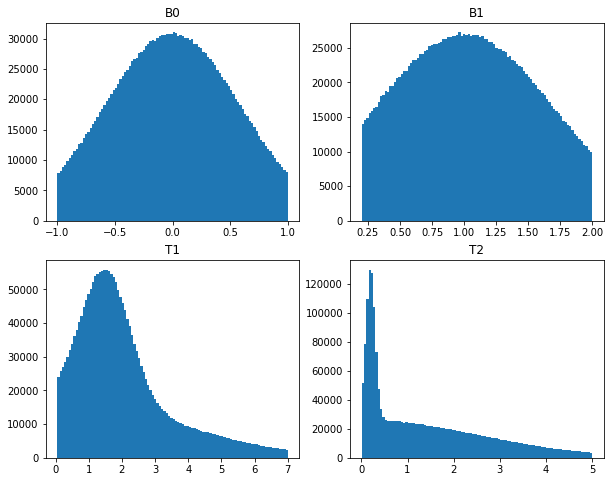

In [9]:
fig, ax = plt.subplots(2,2, figsize=(10,8))
try:
    ax[0,0].hist(pars[:,0], bins=100)
    ax[0,0].set_title('B0')
except:
    pass
try:
    ax[0,1].hist(pars[:,1], bins=100)
    ax[0,1].set_title('B1')
except:
    pass
try:
    ax[1,0].hist(pars[:,2], bins=100)
    ax[1,0].set_title('T1')
except:
    pass
try:
    ax[1,1].hist(pars[:,3], bins=100)
    ax[1,1].set_title('T2')
except:
    pass
plt.show()

# Plot some random spectra

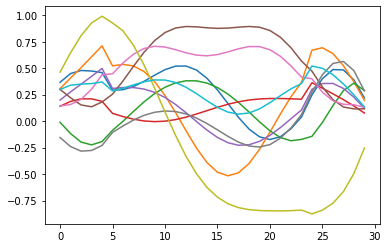

In [10]:
n_spec = 10
fig, ax = plt.subplots()
for i in range(n_spec):
    ax.plot(specs[i+10, 1:])
    

# Reshape & Save

In [11]:
# reshape data and convert to pytorch tensor
X = pytT(specs, dtype=pytFl32)
y = pytT(pars, dtype=pytFl32)

# save data with pytorch
filepath_save_X = os.path.join(subfolder_path, f'{time.strftime("%Y%m%d")}_X_{seq_name}{name_addition}.pt')
filepath_save_y = os.path.join(subfolder_path, f'{time.strftime("%Y%m%d")}_y_{seq_name}{name_addition}.pt')

save (X, filepath_save_X)
save (y, filepath_save_y)

In [12]:
pars.shape

(2097152, 4)

# Save copy of notebook in output folder

In [13]:
from shutil import copy2

current_notebook_name = 'create_data_sweep12.ipynb'
current_notebook_path = os.path.dirname(os.path.realpath("__file__"))

try:
    copy2(os.path.join(current_notebook_path, current_notebook_name),
          os.path.join(subfolder_path, f'{time.strftime("%Y%m%d")}_{seq_name}{name_addition}_create_data.ipynb'))
    print(f'Saved a copy of the current notebook in {subfolder_path}.')
except:
    print(f'Copying {os.path.join(current_notebook_path, current_notebook_name)} to {subfolder_path} failed.')

Saved a copy of the current notebook in /data/schuen02/train_data/example_large/20211119_20210706_WASABITI_sweep12_sim_analytical.
